In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Data preprocessing for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"

## Feature selection 
Enitre workflow with all models for the target variables relative content loss and business reduction (degree of loss) as well for the binary version of relative content loss (chance of loss)

Due to the samll sample size a nested CV is used to have the possibility to even get generalization error, in the inner CV the best hyperaparamters based on k-fold are selected; in the outer cv the generalization error across all tested models is evaluated. A seprate unseen validation set as done by train-test split would have an insufficent small sample size.
Nested CV is computationally intensive but with the samll sample size and a well chosen set of only most important hyperparameters this can be overcome.

- Logistic Regression (binary rcloss)
- Elastic Net
- eXtreme Gradient Boosting
- Conditional Random Forest


In [2]:
import sys
import re
from pathlib import Path
from glob import glob
import numpy as np
import pandas as pd

import pickle
import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_regression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold, RepeatedStratifiedKFold, RepeatedKFold, cross_validate, cross_val_predict
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, PredictionErrorDisplay,  f1_score, confusion_matrix, mean_absolute_error
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.pipeline import Pipeline

from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

sys.path.insert(0, "../../../")
import utils.utils_feature_selection as fs
import utils.utils_evaluation as e
import utils.utils_figures as f
import utils.settings as s
import utils.pipelines as p
import utils.utils_processing as pp

#me = e.model_evaluation()
p.main()  # create/update model settings
#s.init()
seed = s.seed

pd.set_option('display.max_columns', None)
plt.figure(figsize=(20, 10))

import contextlib
import warnings
warnings.filterwarnings('ignore')


targets = ["Target_relative_contentloss_euro", "Target_businessreduction"]
target = targets[1]


c:\Anaconda\envs\py396_c3\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


<Figure size 2000x1000 with 0 Axes>

#### Load R packages to process Conditional Random Forest in python
*Note 1: all needed R packages have to be previously loaded in R*

*Note 2: Make sure that caret package version >= 6.0-81, otherwise caret.train() throws an error*

In [4]:
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr, data
import rpy2.robjects.packages as rpackages


# get basic R packages
utils = importr('utils')
base = importr('base')
dplyr = importr('dplyr')
stats_r = importr("stats")  # rename due to similar python package

# pandas.DataFrames to R dataframes 
from rpy2.robjects import pandas2ri, Formula
pandas2ri.activate()

# print r df in html
import rpy2.ipython.html
rpy2.ipython.html.init_printing()


# get libraries for CRF processing, ctree_controls etc
#partykit = importr('partykit') # for single Conditional Inference tree
party = importr('party')        # Random Forest with Conditional Inference Trees (Conditional Random Forest)
permimp = importr('permimp')  # conditional permutation feature importance
caret = importr('caret') # package version needs to be higher than  >=  6.0-90
nestedcv = importr('nestedcv')
tdr = importr("tdr")


In [5]:
#df_candidates = pd.read_excel("../../../input_survey_data/input_data_contentloss_tueb.xlsx")
df_candidates = pd.read_excel("../../../input_survey_data/input_data_businessreduction_tueb.xlsx")


print(df_candidates.shape)
df_candidates.tail(2)

(393, 17)


,Target_businessreduction,inundation_duration_h,water_depth_cm,flowvelocity,flood_experience,bage,b_area,shp_employees,shp_avgmonthly_sale,hh_monthly_income,emergency_measures,precautionary_measures_lowcost,precautionary_measures_expensive,resilience,resilienceLeftAlone,contaminations,shp_content_value_euro
391,NaN,4.0,70.0,0.1,76,NaN,130.0,2,20.0,NaN,0.333333,0.50,0.333333,1.0,5.0,1,NaN
392,0.0,3.0,100.0,0.1,36,5.0,33.0,2,20.0,0.0,0.333333,0.25,0.000000,0.0,2.5,1,NaN


In [6]:
### TODO impl this cell in data_cleaning

# try:
#     df_candidates = df_candidates.drop("elevation_building_height_cm", axis=1)
# #     #df_candidates = df_candidates.drop("resilience_govern_careing_increases", axis=1)
# except:
#     pass


print(df_candidates.shape)
df_candidates.tail(2)

(393, 17)


,Target_businessreduction,inundation_duration_h,water_depth_cm,flowvelocity,flood_experience,bage,b_area,shp_employees,shp_avgmonthly_sale,hh_monthly_income,emergency_measures,precautionary_measures_lowcost,precautionary_measures_expensive,resilience,resilienceLeftAlone,contaminations,shp_content_value_euro
391,NaN,4.0,70.0,0.1,76,NaN,130.0,2,20.0,NaN,0.333333,0.50,0.333333,1.0,5.0,1,NaN
392,0.0,3.0,100.0,0.1,36,5.0,33.0,2,20.0,0.0,0.333333,0.25,0.000000,0.0,2.5,1,NaN


In [7]:
## delete features with more than 10% missing values
#print("Percentage of missing values per feature [%]\n", round(df_candidates.isna().mean().sort_values(ascending=False)[:15]  * 100), 2) 
df_candidates.isna().mean()

Target_businessreduction            0.091603
inundation_duration_h               0.022901
water_depth_cm                      0.002545
flowvelocity                        0.000000
flood_experience                    0.000000
bage                                0.068702
b_area                              0.005089
shp_employees                       0.000000
shp_avgmonthly_sale                 0.000000
hh_monthly_income                   0.055980
emergency_measures                  0.000000
precautionary_measures_lowcost      0.000000
precautionary_measures_expensive    0.000000
resilience                          0.000000
resilienceLeftAlone                 0.000000
contaminations                      0.000000
shp_content_value_euro              0.157761
dtype: float64

In [8]:
## keep reislience and perception indicator
# df_candidates = df_candidates.loc[:,df_candidates.filter(regex="^(?!resilience_*)").columns]
# df_candidates = df_candidates.loc[:,df_candidates.filter(regex="^(?!perception_*)").columns]


### Correlations between candidate predictors and targets

In [9]:
# from scipy import stats

# def corrdot(*args, **kwargs):
#     corr_r = args[0].corr(args[1], method="spearman", min_periods=100)
#     #corr_r = args[0].corr(args[1], 'pearson')
#     corr_text = round(corr_r, 2)
#     ax = plt.gca()
#     font_size = abs(corr_r) * 80 + 5
#     ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
#                 ha='center', va='center', fontsize=font_size)

# def corrfunc(x, y, **kws):
#     r, p = stats.pearsonr(x, y)
#     p_stars = ''
#     if p <= 0.05:
#         p_stars = '*'
#     if p <= 0.01:
#         p_stars = '**'
#     if p <= 0.001:
#         p_stars = '***'
#     ax = plt.gca()
#     ax.annotate(p_stars, xy=(0.65, 0.6), xycoords=ax.transAxes,
#                 color='red', fontsize=70)



In [10]:
# df = df_candidates
# df = df.dropna()

# sns.set(style='white', font_scale=1.6)

# g = sns.PairGrid(df, aspect=1.5, diag_sharey=False, despine=False)
# g.map_lower(sns.regplot, lowess=True, ci=False,
#             line_kws={'color': 'red', 'lw': 1},
#             scatter_kws={'color': 'black', 's': 20})
# g.map_diag(sns.distplot, color='black',
#            kde_kws={'color': 'red', 'cut': 0.7, 'lw': 1},
#            hist_kws={'histtype': 'bar', 'lw': 2,
#                      'edgecolor': 'k', 'facecolor':'grey'})
# g.map_diag(sns.rugplot, color='black')
# g.map_upper(corrdot)
# g.map_upper(corrfunc)
# g.fig.subplots_adjust(wspace=0, hspace=0)

# # Remove axis labels
# for ax in g.axes.flatten():
#     ax.set_ylabel('')
#     ax.set_xlabel('')

# # Add titles to the diagonal axes/subplots
# for ax, col in zip(np.diag(g.axes), df.columns):
#     ax.set_title(col, y=0.82, fontsize=26)

In [11]:

from sklearn.inspection import permutation_importance
type(df_candidates)

pandas.core.frame.DataFrame

## Fit model 

In [5]:
class ModelFitting(object):

    def __init__(self, model, Xy, target_name, param_space, seed):
        #super(model_fitting, self).__init__()  # super() == to call parent class
        ## properties
        self.model = model   
        self.X = pd.DataFrame(Xy.drop(target_name, axis=1))
        self.X = pd.DataFrame(
                MinMaxScaler().fit_transform(self.X),   
                columns=self.X.columns) 
        self.y: pd.DataFrame = Xy[target_name]
        self.param_space = param_space
        self.k_folds: int = 5
        self.inner_cv = RepeatedKFold(n_splits=self.k_folds, n_repeats=10, random_state=seed)
        self.outer_cv = RepeatedKFold(n_splits=self.k_folds, n_repeats=10, random_state=seed)
        self.seed: int = seed

    def model_fit_ncv(self): #, **kwargs):
        # sourcery skip: inline-immediately-returned-variable
    #def model_fit(self, **kwargs):
        #model = self.model#kwargs["model"]

        ## define inner cv, model training with hyperparameter tuning
        models_trained_ncv = RandomizedSearchCV( # GridSearchCV( 
            estimator=self.model ,
            param_distributions=self.param_space,
            cv=self.inner_cv, 
            scoring="neg_mean_absolute_error",
            refit=True,   
            random_state=self.seed,
        )
        return models_trained_ncv
        #return super().model_fit_ncv(**kwargs)
    
    def final_model_fit(self):
        """
        Train final model on entire dataset to get Variable Selection
        return: best-performed sklearn model
        """
        final_model = RandomizedSearchCV(
            estimator=self.model,
            param_distributions=self.param_space,
            cv=self.outer_cv, 
            scoring="neg_mean_absolute_error",
            refit=True,   
            random_state=self.seed,
        )
        final_model.fit(self.X, self.y)
        
        return final_model.best_estimator_


    # ## decorator for R model
    # def decorator_func(self, model, Xy, target_name, param_space, seed, feature_name, scale=True):
    #     """
    #     Decorator to get partial dependence instead of python-sklearn-model from R-party-model
    #     """
    def r_model_fit_ncv(self):   # fun = call function which should be decorate
            
            # def wrapper(*args, **kwargs):  
                ### no need to call original function due that it is entirely replaced by decorator
                #x = func()

        # ## define inner cv, model training with hyperparameter tuning
        base.set_seed(seed)
        models_trained_ncv = nestedcv.nestcv_train(
            y=self.y, 
            x=self.X,    # tree-based models uses information gain / gini coefficient inherently which will not be affected by scaling 
                            # normalize X --> not mandatory for CRF but solves bug in party.cforest() and potentially decreases processing time
            method="cforest",
            #savePredictions="final", # predictions on inner folds
            outer_train_predict=True, # predictions on outer training fold
            n_outer_folds=self.k_folds,
            n_inner_folds=self.k_folds,
            finalCV=False,  # "NA" final model fitting is skipped altogether, which gives a useful speed boost if performance metrics are all that is needed.
            tuneGrid=e.r_tunegrid(
            self.param_space["mtry"][0], 
            self.param_space["mtry"][1], 
            self.param_space["mtry"][2]
        ), 
        #filterFUN = ttest_filter, filter_options = list(nfilter = 300),
            metric='MAE',#'RMSE',  # RMSE unit of target or use MAE due that more robust than RMSE further metrics options Rsquared, RMSE, MAE 
                # RMSE penalizes large gaps more harshly than MAE
            controls = party.cforest_unbiased(
                ntree = 300,  # didnt improved with 200 or 500 trees
                # mincriterion = 0.05,   # the value of the test statistic (for testtype == "Teststatistic"), or 1 - p-value (for other values of testtype) that must be exceeded in order to implement a split.
            ),  
            trControl = caret.trainControl(
                method = "repeatedcv",  # "oob" - then no repeats are needed
                number = self.k_folds,   ## = number of splits
                repeats = self.k_folds,  #  nbr repeats == number of tried values for mtry
                savePredictions = "final"  # saves predictions from optimal tuning parameters
            )
        )
        print("\nSummary CRF \n", base.summary(models_trained_ncv))
        
        return models_trained_ncv
            

    def r_final_model_fit(models_trained_ncv):
        # sourcery skip: inline-immediately-returned-variable
        """
        """
        best_hyperparameters = fs.r_dataframe_to_pandas(fs.r_best_hyperparamters(models_trained_ncv))
        final_model = party.cforest(Formula(f'{target_name} ~ .'),  
            data=pd.concat([self.y.reset_index(), self.X],   # use normalized X
                    axis=1,
                ).drop("index", axis=1),
            control= party.cforest_unbiased(mtry=best_hyperparameters.mtry, ntree=300)
        )
        return final_model

    # return r_model_fit_ncv, r_final_model_fit


In [13]:
    # ## decorator for R model
    # def decorator_func(self, model , Xy, y_name, feature_name, scale=True):
    #     """
    #     Decorator to get partial dependence instead of python-sklearn-model from R-party-model
    #     """
    #     def r_get_partial_dependence(func):
    #         def wrapper(*args, **kwargs):
    #             ...
    #             #return func(*args, **kwargs)
    #             return fs.r_dataframe_to_pandas(partial_dep)
    #         return wrapper
    #     return r_get_partial_dependence


    # #@decorator(model=final_models_trained["crf"], Xy=eval_set_list["crf"]["crf"], target_name=target, feature_name="flowvelocity", scale=True) 
    # ## not using decorator @
    # def get_partial_dependence(self, **kwargs):
    #     model= kwargs["model"]

In [18]:
class ModelEvaluation(object):
    """
    
    """        
    def __init__(self, models_trained_ncv, Xy, target_name, score_metrcis, seed):
        #super(model_fitting, self).__init__()
        self.models_trained_ncv = models_trained_ncv
        self.X = pd.DataFrame(Xy.drop(target_name, axis=1))
        self.X = pd.DataFrame(
                MinMaxScaler().fit_transform(self.X),   
                columns=self.X.columns) 
        self.y: pd.DataFrame = Xy[target_name]
        self.outer_cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=seed)
        self.k_folds:int = 10
        self.score_metrcis = score_metrcis
        self.seed: int = seed


    def model_evaluate_ncv(self):
        """  
        
        """    
        ## predict y on outer folds of nested cv
        y_pred = cross_val_predict(
            self.models_trained_ncv,  # estimators from inner cv
            self.X, self.y,
            cv=self.k_folds, # KFold without repeats to have for each sample one predicted value 
            method="predict"
        )

        ## get generalization performance on outer folds of nested cv
        model_performance_ncv = cross_validate(
            self.models_trained_ncv, 
            self.X, self.y, 
            scoring=self.score_metrcis,  # Strategies to evaluate the performance of the cross-validated model on the test set.
            cv=self.outer_cv, 
            return_estimator=True,
        ) 
        print(
            "model performance for MAE (std) of outer CV: %.3f (%.3f)"%(
                model_performance_ncv["test_MAE"].mean(), np.std(model_performance_ncv["test_MAE"])
            ))
        
        return y_pred, model_performance_ncv


    def permutation_feature_importance(self, final_model, Xy, target_name, repeats=10, seed=seed):
    #def permutation_feature_importance(model, X_test, y_test, y_pred, criterion= r2_score):
        """
        Calculate permutation based feature importance , the importance scores represents the increase in model error
        final_model : final sklearn model
        Xy : pd.Dataframe with predictors and response variable <target_name>
        target_name (str): name of response variable 
        criterion : sklearn evaluation metrics, default r2_score 
        
        return: pd DataFrame with importance scores
        """
        permutation_fi = permutation_importance(final_model, Xy.drop(target_name, axis=1), Xy[target_name], n_repeats=repeats, random_state=seed)

        return permutation_fi.importances_mean, permutation_fi.importances_std, permutation_fi.importances


    def r_model_evaluate_ncv(self, models_trained_ncv):
        """ 
        """            
        ## predict y based on outer folds of nested cv
        y_pred = nestedcv.train_preds(models_trained_ncv) 

        ## get generalization performance on outer folds of nested cv
        model_performance_ncv = {
            "test_MAE_old" : base.summary(models_trained_ncv)[3][2],
            "test_MAE" : e.mean_absolute_error(self.y, y_pred),
            "test_RMSE" : e.root_mean_squared_error(self.y, y_pred),
            "test_MBE" : e.mean_bias_error(self.y, y_pred),
            "test_R2": e.r2_score(self.y, y_pred),
            "test_SMAPE" : e.symmetric_mean_absolute_percentage_error(self.y, y_pred),
        }
        return y_pred, model_performance_ncv
            
            
    def r_permutation_feature_importance(self, final_model):  # final_model):
        # sourcery skip: inline-immediately-returned-variable
        """  
        """ 
        importances = permimp.permimp(
            self, final_model, threshold=0.95, conditional=True, progressbar=False
        )
        return importances



#######################################################################################
# pipe = joblib.load('./pipelines/pipe_en.pkl')
# hyperparams_set = pp.load_config("../../../utils/hyperparameter_sets.json")

# model_fitting(
#    # model=pipe, 
#     Xy=df_candidates,
#     target_name=target,
#     param_space=hyperparams_set["xgb_hyperparameters"],
#     score_metrcis=score_metrcis,
#     seed=s.seed
#     ).model_fit(pipe)

# df_candidates = df_candidates.dropna()
# model_fitting(
#     model=pipe, 
#     Xy=df_candidates,
#     target_name=target,
#     param_space=hyperparams_set["en_hyperparameters"],
#     score_metrcis=score_metrcis,
#     seed=s.seed

#     ).model_fit()  # pipe


In [19]:
# ## decorator for R model
# def decorator_func(self, model_pipe, model_fitted , Xy, y_name, feature_name, scale=True):
#     """
#     Decorator to get partial dependence instead of python-sklearn-model from R-party-model
#     """
#     def r_model_fit_ncv(func):
#         def wrapper(*args, **kwargs):
#             ## normalize X --> not mandatory for CRF but solves bug in party.cforest() and potentially decreases processing time
            
#             # ## define inner cv, model training with hyperparameter tuning
#             base.set_seed(seed)
#             models_trained_ncv = nestedcv.nestcv_train(
#                 y=self.y, 
#                 x=self.X,    # tree-based models uses information gain / gini coefficient inherently which will not be affected by scaling 
#                 method="cforest",
#                 #savePredictions="final", # predictions on inner folds
#                 outer_train_predict=True, # predictions on outer training fold
#                 n_outer_folds=2,
#                 n_inner_folds=2,
#                 finalCV=False,  # "NA" final model fitting is skipped altogether, which gives a useful speed boost if performance metrics are all that is needed.
#                 tuneGrid=e.r_tunegrid(self.param_space["mtry"][0], self.param_space["mtry"][1], self.param_space["mtry"][2]), 
#                 #filterFUN = ttest_filter, filter_options = list(nfilter = 300),
#                 metric='MAE',#'RMSE',  # RMSE unit of target or use MAE due that more robust than RMSE further metrics options Rsquared, RMSE, MAE 
#                     # RMSE penalizes large gaps more harshly than MAE
#                 controls = party.cforest_unbiased(
#                     ntree = 300,  # didnt improved with 200 or 500 trees
#                     # mincriterion = 0.05,   # the value of the test statistic (for testtype == "Teststatistic"), or 1 - p-value (for other values of testtype) that must be exceeded in order to implement a split.
#                 ),  
#                 trControl = caret.trainControl(
#                     method = "repeatedcv",  # "oob" - then no repeats are needed
#                     number = 2,   ## = number of splits
#                     repeats = 2,  #  nbr repeats == number of tried values for mtry
#                     savePredictions = "final"  # saves predictions from optimal tuning parameters
#                 )
#             )
#             print("\nSummary CRF \n", base.summary(models_trained_ncv))
#             return models_trained_ncv
#         return wrapper


    # def r_model_evaluate_ncv(self, models_trained_ncv):
    #     """ 
    #     """
    #     def wrapper(*args, **kwargs):
            
    #         ## predict y based on outer folds of nested cv
    #         y_pred = nestedcv.train_preds(models_trained_ncv) 

    #         ## get generalization performance on outer folds of nested cv
    #         model_performance_ncv = {
    #             "test_MAE_old" : base.summary(models_trained_ncv)[3][2],
    #             "test_MAE" : e.mean_absolute_error(self.y, y_pred),
    #             "test_RMSE" : e.root_mean_squared_error(self.y, y_pred),
    #             "test_MBE" : e.mean_bias_error(self.y, y_pred),
    #             "test_R2": e.r2_score(self.y, y_pred),
    #             "test_SMAPE" : e.symmetric_mean_absolute_percentage_error(self.y, y_pred),
    #         }

    #         return y_pred, model_performance_ncv
    #     return wrapper
            
    # def r_final_model_fit(func, **kwargs):
    #     """
    #     """
    #     def wrapper(models_trained_ncv_ncv, *args, **kwargs):

    #         best_hyperparameters = fs.r_dataframe_to_pandas(fs.r_best_hyperparamters(models_trained_ncv))
    #         final_model = party.cforest(Formula(f'{y_name} ~ .'),  
    #             data=pd.concat([self.y.reset_index(), self.X],   # use normalized X
    #                     axis=1,
    #                 ).drop("index", axis=1),
    #             control= party.cforest_unbiased(mtry=best_hyperparameters.mtry, ntree=300)
    #         )
    #         return final_model
    #     return wrapper
    
    # def r_feature_importance(final_model):
    #     """  
    #     """ 
    #     importances = permimp.permimp(   # faster and more stable than party.varimp()
    #         final_model, 
    #         threshold = .95,   # # party.varimp()= threshold=.2 , threshold < .5 makes FI too greedy
    #         conditional=True, 
    #         progressbar=False
    #     )
    #     return importances
    
    #return r_model_fit_ncv, r_model_evaluate_ncv, 

    #return r_get_partial_dependence, r_model_fit

In [ ]:
score_metrcis = {
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "RMSE": make_scorer(e.mean_bias_error, greater_is_better=False),
    "MBE": make_scorer(e.mean_bias_error, greater_is_better=False),
    "R2": "r2",
    "SMAPE": make_scorer(e.symmetric_mean_absolute_percentage_error, greater_is_better=False)
}



In [1]:
## iterate over piplines. Each piplines contains precrosseing methods and several  classifier
#pipelines = ["pipe_en", "pipe_crf", "pipe_xgb"]
#pipelines = ["pipe_en", "pipe_xgb"]  
pipelines = ["pipe_crf"]

eval_sets = {}
models_trained = {}
final_models_trained = {}
model_coef = {}
predicted_values = {}
df_feature_importances = pd.DataFrame(index=df_candidates.drop(target, axis=1).columns.to_list())
models_scores = {}


## Load set of hyperparamters
hyperparams_set = pp.load_config("../../../utils/hyperparameter_sets.json")


for pipe_name in pipelines:

    # model_name = re.findall("[a-zA-Z]+", str(pipe.steps[1][1].__class__).split(".")[-1])[0] # works only for python models TODO get this for R model, 
    model_name = pipe_name.split('_')[1]
    print( f"\nApplying {model_name} on {target}:")

    df_Xy = df_candidates
    X_names = df_Xy.drop(target, axis=1).columns.to_list()

    if (target == "Target_relative_contentloss_euro"):
        print(f"Removing {df_Xy.loc[df_Xy[target]==0.0,:].shape[0]} zero loss records")
        df_Xy = df_Xy.loc[df_Xy[target]!=0.0,:]
        print(f"Keeping {df_Xy.shape} damage cases for model training and evaluation")

    ## drop samples where target is nan
    print(f"Dropping {df_Xy[f'{target}'].isna().sum()} records from entire dataset due that these values are nan in target variable")
    df_Xy = df_Xy[ ~df_Xy[f"{target}"].isna()]

    ## EN: drop samples where any value is nan
    if (model_name == "en") | (model_name == "crf"):
        df_Xy.dropna(inplace=True)

    print(
        "Using ",
        df_Xy.shape[0],
        " records, from those are ",
        {(df_Xy[target][df_Xy[target] == 0.0]).count()},
        " cases with zero-loss or zero-reduction",
    )

    X = df_Xy[X_names]
    y = df_Xy[target]


    ## load model pipelines and hyperparameter space
    pipe = joblib.load(f'./pipelines/{pipe_name}.pkl')
    param_space = hyperparams_set[f"{model_name}_hyperparameters"]

    if "bag" in pipe_name.split("_"):
        print(f"Testing {model_name} with bagging")
        param_space = { k.replace('model', 'bagging__estimator') : v for (k, v) in param_space.items()}



    if model_name != "crf":

        # ## save evaluation set for later usage in feature importance
        # eval_sets[f"{model_name}"] = df_Xy #pd.concat([df_Xy[target], X_crf], axis=1) 

        mf = ModelFitting(
            model=pipe, 
            Xy=df_Xy,
            target_name=target,
            param_space=hyperparams_set[f"{model_name}_hyperparameters"],
            seed=s.seed,
        )
        models_trained_ncv = mf.model_fit_ncv()  # pipe
        final_model = mf.final_model_fit()
        
        me = ModelEvaluation(
            model=models_trained_ncv, 
            Xy=df_Xy,
            target_name=target,
            score_metrcis=score_metrcis,
            seed=s.seed
        )
        y_pred, model_evaluation_results = me.model_evaluate_ncv(models_trained_ncv)

        ## Feature importance of best model
        importances = me.permutation_feature_importance(final_model, df_Xy, target, repeats=5, seed=seed)


        ## get coefficient of each predictor
        with contextlib.suppress(Exception):   # <-- better than: try and bare except
            model_coefs = final_model.best_estimator_.named_steps['model'].coef_
            model_intercept = final_model.best_estimator_.named_steps['model'].intercept_
            print(f"Intercept for {model_name}: {model_intercept}")
            model_coef[f"{model_name}"] = pd.DataFrame(zip(X.columns, model_coefs), columns=['features', 'coef']) 

            ## Calcualte significance of coefficients
            ## https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression
            params = np.append(model_intercept, list(model_coefs[0]))
            newX = np.append(
                np.ones(
                    (len(X),1)
                ), 
                X, axis=1
            )
            MSE = (sum((y-y_pred)**2))/(len(newX)-len(newX.columns))

            var_b = MSE*(np.linalg.inv(np.dot(newX.T, newX)).diagonal())
            sd_b = np.sqrt(var_b)
            ts_b = params / sd_b

            p_values = [2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX.columns)-1))) for i in ts_b]
            sd_b = np.round(sd_b,3)
            ts_b = np.round(ts_b,3)
            p_values = np.round(p_values,5)
            params = np.round(params,4)

            df_coefs = pd.DataFrame()
            df_coefs["Coefficients"], df_coefs["Standard Errors"], df_coefs["t values"], df_coefs["Probabilities"] = [params, sd_b, ts_b, p_values]
            model_coef[f"{model_name}_selfbuilt"] = df_coefs
            model_coef[f"{model_name}_selfbuilt"]["features"] =  ["intercept"] + X.columns.to_list()


    if model_name == "crf":

        ## normalize X 
        ## not mandatory for CRF but solves bug in party.cforest() and potentially decreases processing time
        # X_crf = pd.DataFrame(MinMaxScaler().fit_transform(X),   
        #     columns=df_Xy.loc[:, df_Xy.columns!=target].columns
        # )    
        # # ## save evaluation set for later usage in feature importance
        # eval_sets[f"{model_name}"] = pd.concat([df_Xy[target], X_crf], axis=1) 

        ## define model settings
        mf = ModelFitting(
            model=pipe, 
            Xy=df_Xy,
            target_name=target,
            param_space=hyperparams_set[f"{model_name}_hyperparameters"],
            seed=s.seed
        )
        models_trained_ncv = mf.r_model_fit_ncv()  # pipe
        final_model = mf.r_final_model_fit()
        
        me = ModelEvaluation(
            model=models_trained_ncv, 
            Xy=df_Xy,
            target_name=target,
            seed=s.seed
        )
        y_pred, model_evaluation_results = me.r_model_evaluate_ncv(models_trained_ncv)
        
        ## Feature importance of best model
        importances = me.r_permutation_feature_importance(final_model, df_Xy, target, repeats=5, seed=seed)


    # filename = f'./models_trained_ncv/{model_name}_{target}.sav'
    # pickle.dump(model, open(filename, 'wb'))
    eval_sets[model_name] = df_Xy
    models_scores[model_name] = model_evaluation_results ## store performance scores 
    models_trained[f"{model_name}_innercv"] = models_trained_ncv
    models_trained[model_name] = model_evaluation_results["estimator"]
    predicted_values[model_name] = pd.DataFrame({"y_empirical": y, "y_predicted": y_pred})
    final_models_trained[model_name] = final_model

    ## Feature importance
    print("\nSelect features based on permutation feature importance")
    df_importance = pd.DataFrame(
        {
            f"{model_name}_importances" : importances[0],   # mean importnaces across repeats
            f"{model_name}_importances_std" : importances[1]
        },
        index=X_names,
    )
    df_feature_importances = df_feature_importances.merge(
        df_importance[f"{model_name}_importances"],   # only use mean FI, drop std of FI
        left_index=True, right_index=True, how="outer")


    #df_importance = df_importance.sort_values(f"{model_name}_importances", ascending=False)  # get most important features to the top
    print("5 most important features:", df_importance.iloc[:5].index.to_list())
    #df_importance = df_importance.loc[df_importance[f"{model_name}_importances"] >= 0.000000, : ]


 
 # EN MAE 0.063 
#     RMSE   Rsquared        MAE   
#   0.13054    0.01451    0.05986   


model performance for MAE (std) of outer CV: -19.236 (1.867)

Select features based on permutation feature importance


In [ ]:
# from sklearn.feature_selection import SelectFromModel
# model = SelectFromModel(model_cv_result["estimator"][10].best_estimator_.named_steps['model'], prefit=True)
# X_new = model.transform(X)
# X_new


In [26]:
y_pred.shape

(278,)

In [ ]:
## visual check if hyperparameter ranges are good
for i in range(0,49):
    print(models_scores["en"]["estimator"][i].best_params_)

## closs

## Bred
# {'model__seed': 42, 'model__n_estimators': 400, 'model__max_depth': 7, 'model__booster': 'gblinear'}
# {'model__tol': 0.5, 'model__selection': 'random', 'model__random_state': 42, 'model__max_iter': 4, 'model__l1_ratio': 0.0, 'model__alpha': 1}


{'model__tol': 0.5, 'model__selection': 'random', 'model__random_state': 42, 'model__max_iter': 6, 'model__l1_ratio': 1.0, 'model__alpha': 0.5}
{'model__tol': 0.5, 'model__selection': 'random', 'model__random_state': 42, 'model__max_iter': 6, 'model__l1_ratio': 1.0, 'model__alpha': 0.5}
{'model__tol': 0.5, 'model__selection': 'random', 'model__random_state': 42, 'model__max_iter': 6, 'model__l1_ratio': 1.0, 'model__alpha': 0.5}
{'model__tol': 0.5, 'model__selection': 'random', 'model__random_state': 42, 'model__max_iter': 6, 'model__l1_ratio': 1.0, 'model__alpha': 0.5}
{'model__tol': 0.5, 'model__selection': 'random', 'model__random_state': 42, 'model__max_iter': 6, 'model__l1_ratio': 1.0, 'model__alpha': 0.5}
{'model__tol': 0.5, 'model__selection': 'random', 'model__random_state': 42, 'model__max_iter': 6, 'model__l1_ratio': 1.0, 'model__alpha': 0.5}
{'model__tol': 0.7, 'model__selection': 'random', 'model__random_state': 42, 'model__max_iter': 6, 'model__l1_ratio': 0.25, 'model__alph

## Evaluation
Evaluate models based on performance on outer cross-validation 

In [ ]:
## get std of CRF from inner folds
l = []
for idx in range(1,10):  # number of estimators in outer folds
    
    df = e.r_models_cv_predictions(models_trained["crf"], idx)

    mae = mean_absolute_error(df.testy, df.predy)
    rmse =  np.sqrt( np.mean((df.testy - df.predy)**2) ) #(df.testy, df.predy)
    mbe = e.mean_bias_error(df.testy, df.predy)
    r2 = mean_absolute_error(df.testy, df.predy)
    smape = e.symmetric_mean_absolute_percentage_error(df.testy, df.predy)
    l.append([mae, rmse, mbe, r2, smape ])


In [ ]:
print("CRF: mean of evaluation scores and their standard deviation across tested models in inner cv:",
        f"\nmae_mean, mae_std: {np.mean([score[0] for score in l]), np.std([score[0] for score in l]) } ",
        f"\nrmse_mean, rmse_std: {np.mean([score[1] for score in l]), np.std([score[1] for score in l]) } ",
        f"\nmbe_mean, mbe_std: {np.mean([score[2] for score in l]), np.std([score[2] for score in l]) } ",
        f"\nr2_mean, r2_std: {np.mean([score[3] for score in l]), np.std([score[3] for score in l]) } ",
        f"\nsmape_mean, smape_std: {np.mean([score[4] for score in l]), np.std([score[4] for score in l]) } ",
)

print("\nElastic Net: mean of evaluation scores and their standard deviation across tested models in inner cv:",
    pd.concat([
            pd.DataFrame(models_scores["en"]).drop("estimator",axis=1).mean(axis=0),
            pd.Series(pd.DataFrame(models_scores["en"]).drop("estimator",axis=1).std(axis=0))
        ], axis=1
    )
      )

print("\nXGB: mean of evaluation scores and their standard deviation across tested models in inner cv:",
    pd.concat([
            pd.DataFrame(models_scores["xgb"]).drop("estimator",axis=1).mean(axis=0),
            pd.Series(pd.DataFrame(models_scores["xgb"]).drop("estimator",axis=1).std(axis=0))
        ], axis=1
    )
    )

# EN
# test_neg_MAE    -0.062560  0.019390
# test_neg_RMSE   -0.113259  0.069073
# test_MBE        -0.000050  0.032531
# test_R2         -0.432757  1.121662
# test_SMAPE    -127.259363  9.495025

# XGB: mean of evaluation scores and their standard deviation across tested models in inner cv:                         0          1
# fit_time        21.798437   0.712181
# score_time       0.012409   0.002156
# test_neg_MAE    -0.067284   0.018891
# test_neg_RMSE   -0.142585   0.061684


## best model for BRed : XGB test_MAE    -16.769906    2.025747  (no subsampling of feautres)
## best model for BRed : XGB test_MAE    -16.007160    1.684777  (with subsampling of feautres) 


CRF: mean of evaluation scores and their standard deviation across tested models in inner cv: 
mae_mean, mae_std: (17.582441342601694, 1.7051564553195657)  
rmse_mean, rmse_std: (23.15409601695462, 1.6993064172936712)  
mbe_mean, mbe_std: (-0.019844803623277056, 1.7691556798769434)  
r2_mean, r2_std: (17.582441342601694, 1.7051564553195657)  
smape_mean, smape_std: (115.93473399941175, 8.834002462010186) 

Elastic Net: mean of evaluation scores and their standard deviation across tested models in inner cv:                      0         1
fit_time      5.928089  1.033562
score_time    0.006096  0.007454
test_MAE    -19.236208  1.885694
test_RMSE     0.000901  3.504235
test_MBE      0.000901  3.504235
test_R2      -0.003935  0.058048
test_SMAPE -120.502866  8.468869

XGB: mean of evaluation scores and their standard deviation across tested models in inner cv:                      0          1
fit_time     48.171497  19.732239
score_time    0.014109   0.005132
test_MAE    -16.238530   1.

In [ ]:
xgb_model_evaluation = pd.DataFrame(models_scores["xgb"]).drop("estimator",axis=1).mean(axis=0)  # get mean of outer cv metrics (negative MAE and neg RMSE, pos. R2, pos MBE, posSMAPE)
#crf_model_evaluation = pd.DataFrame(models_scores["crf"]).mean(axis=0)
en_model_evaluation = pd.DataFrame(models_scores["en"]).drop("estimator",axis=1).mean(axis=0)

# Applying xgb on Target_relative_contentloss_euro:
# outer CV: MAE: -0.095 (0.032)


## TODO add/derive MBE, MAPE of CRF
crf_model_evaluation = pd.DataFrame({
    "crf": [None, 
            None,
            round(np.mean([score[0] for score in l]), 3), # MAE
            round(np.mean([score[1] for score in l]), 3),  # RMSE
            round(np.mean([score[2] for score in l]), 3), # MBE 
            round(np.mean([score[3] for score in l]), 3),  # R2
            round(np.mean([score[4] for score in l]), 3), # SMAPE 
            ]

    }, index=xgb_model_evaluation.index
)

model_evaluation = pd.concat([en_model_evaluation, xgb_model_evaluation, crf_model_evaluation], axis=1)
model_evaluation.columns = ["en", "xgb", "crf"]
model_evaluation.index = model_evaluation.index.str.replace("neg_", "")
model_evaluation.loc["test_MAE"] = model_evaluation.loc["test_MAE"].abs()
model_evaluation.loc["test_RMSE"] = model_evaluation.loc["test_RMSE"].abs()


model_evaluation.round(3)

,en,xgb,crf
fit_time,5.928,48.171,NaN
score_time,0.006,0.014,NaN
test_MAE,19.236,16.239,17.582
test_RMSE,0.001,3.275,23.154
test_MBE,0.001,-3.275,-0.020
test_R2,-0.004,0.049,17.582
test_SMAPE,-120.503,-130.002,115.935


### Coefficients of Elastic Net

EN: The coefficients of elastic net regression represent the linear relationship between the features and the target variable, adjusted by the regularization terms. The larger the absolute value of a coefficient, the stronger the effect of the corresponding feature on the target variable. The sign of a coefficient indicates the direction of the effect. 

**Note: The regularization reduces the influence of correlated variables on the model because the weight is shared between the two predictive variables, so neither alone would have strong weights.**

[https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#checking-the-variability-of-the-coefficients]


sklearn:
odds_ratio = exp(coef)
where exp is the exponential function and coef is the coefficient for the input variable. The odds_ratio represents the change in the odds of the output variable for a one-unit increase in the input variable. A value greater than 1 indicates that the odds of the output variable increase with an increase in the input variable

In [ ]:
#.reset_index(drop=True).set_index(list(X.columns).insert(0, "intercept"))

#model_coef[f"en_selfbuilt"]
model_coef#["en_selfbuilt"].sort_values("Probabilities")


{}

In [ ]:
# #import statsmodels.api as sm

# print(model_coef.keys())
# print(
#     "Regularization type, [0.0:Ridge, 1.0:Lasso] :",
#     models_trained["en"].best_params_["model__l1_ratio"]
#     ) # L2 === Ridge Regression --> got coefs | L1 ==LASSO , got only zero coefs for all features
# print(model_coef["en"].sort_values("coef", key=abs, ascending=False).head(10))

## Interpretation of coefficients:
#  Without normalization: e.g increase of 1 year in AGE means a decrease of <coef_value> of the target in its unit, 
#  On the other hand, categorical variables (as UNION or SEX) are adimensional numbers taking either the value 0 or 1 (<-were hot-encoded). 
# Their coefficients are expressed in target unit. Then, we cannot compare the magnitude of different coefficients since the features 
# have different natural scales, and hence value ranges, because of their different unit of measure. 
# [https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#checking-the-variability-of-the-coefficients]


## summary signe and signifcance is enough : summairzed version

### Testing: self-built p-values VS  p-valued from statsmodels

In [ ]:
# import statsmodels.api as sm
# from scipy import stats

# X_exog = MinMaxScaler().fit_transform(df_Xy.drop(target, axis=1))
# X_exog = sm.add_constant(X_exog) #df_Xy.drop(target, axis=1))#, prepend=False)

# m = sm.OLS(y, X_exog)
# m_res = m.fit()
# print(m_res.summary())


In [ ]:
#     Coefficients  Standard Errors  t values  Probabilities
# 0 intercpt -0.0295            0.035    -0.840        0.40226
# 1         0.0253            0.091     0.279        0.78061
# 2        -0.0069            0.050    -0.137        0.89156
# 3         0.0738            0.031     2.343        0.02048
# 4        -0.0096            0.025    -0.390        0.69703
# 5        -0.0216            0.046    -0.475        0.63558
# 6         0.0182            0.046     0.395        0.69337
# 7         0.0871            0.103     0.845        0.39972
# 8         0.4966            0.245     2.025        0.04474
# 9        -0.0108            0.107    -0.101        0.91979
# 10        0.0924            0.114     0.812        0.41812
# 11        0.0180            0.037     0.492        0.62363
# 12       -0.0009            0.034    -0.025        0.97994
# 13        0.2980            0.272     1.094        0.27594

In [ ]:
# ## skelarn

# from sklearn.linear_model import LinearRegression

# X_exog = MinMaxScaler().fit_transform(df_Xy.drop(target, axis=1))
# #X_exog = df_Xy.drop(target, axis=1)

# reg = LinearRegression().fit(X_exog, y)
# y_pred = reg.predict(X_exog)
# print(reg.coef_)
# print(reg.intercept_)

# ## Calcualte significance of regression coefficients
# ## https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression
# params = np.append(reg.intercept_, list(reg.coef_))
# # newX = np.append(np.ones((len(X),1)), X, axis=1)
# # MSE = (sum((y - y_pred)**2))/(len(newX)-len(newX[0]))
# newX = pd.DataFrame({"Constant":np.ones(len(X_exog))}).join(pd.DataFrame(X_exog))
# MSE = (sum((y-y_pred)**2))/(len(newX)-len(newX.columns))

# var_b = MSE*(np.linalg.inv(np.dot(newX.T, newX)).diagonal())
# sd_b = np.sqrt(var_b)
# ts_b = params / sd_b

# ## adapted p-values
# p_values = [2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX.columns)-1))) for i in ts_b]
# # p_values = [
# #     2 * ( 1 - stats.t.cdf(
# #         np.abs(i), (len(newX)-len(newX[0]))
# #     )) 
# #     for i in ts_b
# # ]
# sd_b = np.round(sd_b,3)
# ts_b = np.round(ts_b,3)
# p_values = np.round(p_values,5)
# params = np.round(params,4)

# df_coefs = pd.DataFrame()
# df_coefs["Coefficients"], df_coefs["Standard Errors"], df_coefs["t values"], df_coefs["Probabilities"] = [params, sd_b, ts_b, p_values]
# print(df_coefs)
         

#### Coefficient variability

High variabaility indicates possible strong collinearity with other features

Coefficient of ML models are generally unable to infer causal effects.
It might be tempting to look at the coefficient of education on wage from our last model (or any model for that matter) and conclude that it captures the true effect of a change in the standardized education variable on wages.
Unfortunately there are likely **unobserved confounding variables** that either inflate or deflate that coefficient. A confounding variable is a variable that causes both EDUCATION and WAGE.

In [ ]:
cv_en_model = models_scores["en"] ## get scores of each feature in each fold (outer folds * inner folds)
len(cv_en_model["estimator"])

50

In [ ]:
cv_en_model = models_scores["en"] ## get scores of each feature in each fold (outer folds * inner folds)
len(cv_en_model["estimator"])
coefs = pd.DataFrame(
    # [est[-1].best_estimator_.named_steps['model'].coef_ for est in cv_en_model["estimator"]]
    [est.best_estimator_.named_steps['model'].coef_ for est in cv_en_model["estimator"]], columns=X.columns
)


In [ ]:
#coefs.mean(axis=0)

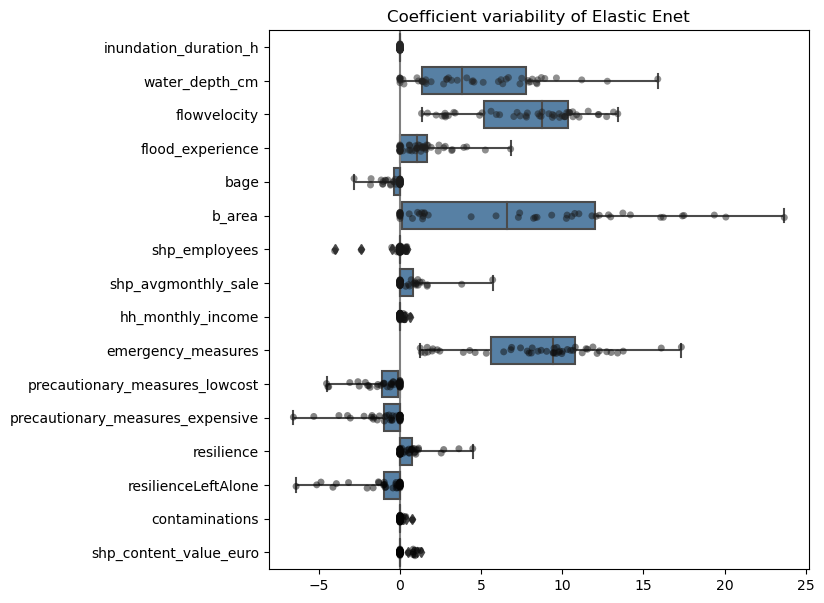

In [ ]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="steelblue", saturation=0.7, whis=100)
plt.axvline(x=0, color=".5")
plt.title("Coefficient variability of Elastic Enet")
plt.subplots_adjust(left=0.3)



--> coefficients of flowvelocity and purchase pumping equipment varying a lot depneding of the fold
--> registered capital, average monthly sale, monthly income coefficients are varying a lot depending of the fold.

**The regularization reduces the influence of correlated variables on the model because the weight is shared between the two predictive variables, so neither alone would have strong weights.**

### Feature Importances 


#### prepare Feature Importances 
Have the same feature importance method across all applied ML models
Weight Importances by model performance on outer loop (mean MAE)

In [ ]:
s = df_feature_importances

In [ ]:
## Overall FI ranking (procedure similar to Rözer et al 2019; Brill 2022)

## scale importance scores to  same units (non important feautres were removed before)
df_feature_importances = pd.DataFrame(
    MinMaxScaler(feature_range=(0,10)).fit_transform(df_feature_importances), 
    index=df_feature_importances.index,
    columns=df_feature_importances.columns
)
print(df_feature_importances.head(2))


        en_importances  crf_importances  xgb_importances
b_area        0.321579         1.846687         2.772674
bage          0.000000         5.195552        10.000000


In [ ]:
## weight FI scores based on performance 
## weigth importances from better performed models more

crf_scores = models_scores[f"crf"] ["MAE"] # outer MAE of CRF

for m in ["xgb", "en"]: 
    df_feature_importances[f"{m}_importances_weighted"] =  df_feature_importances[f"{m}_importances"] / np.abs(models_scores[m]["test_MAE"].mean())
df_feature_importances["crf_importances_weighted"]  = df_feature_importances["crf_importances"] / crf_scores    # weigth better models more

df_feature_importances.head(2)


,en_importances,crf_importances,xgb_importances,xgb_importances_weighted,en_importances_weighted,crf_importances_weighted
b_area,0.321579,1.846687,2.772674,0.170747,0.016717,0.103423
bage,0.000000,5.195552,10.000000,0.615819,0.000000,0.290976


In [ ]:
## overall FI scores
df_feature_importances["mean_all_importances_weighted"] = df_feature_importances[["xgb_importances_weighted","en_importances_weighted", "crf_importances_weighted"]].mean(axis=1)
## drop feautres which are unimportant
df_feature_importances = df_feature_importances.loc[df_feature_importances["mean_all_importances_weighted"] > 0.000000, : ]
print(
    "10 most important features across all models (weighted on mean MAE scores):\n" ,
    #df_feature_importances.overall_importances.sort_values(ascending=False).head()
)
df_feature_importances.sort_values("mean_all_importances_weighted", ascending=False)[:10]#.describe()


10 most important features across all models (weighted on mean MAE scores):



,en_importances,crf_importances,xgb_importances,xgb_importances_weighted,en_importances_weighted,crf_importances_weighted,mean_all_importances_weighted
emergency_measures,7.840035,10.000000,6.237925,0.384143,0.407567,0.560048,0.450586
water_depth_cm,3.038288,9.088221,7.094550,0.436896,0.157946,0.508984,0.367942
flowvelocity,10.000000,4.218263,4.607122,0.283715,0.519853,0.236243,0.346604
bage,0.000000,5.195552,10.000000,0.615819,0.000000,0.290976,0.302265
shp_content_value_euro,0.000000,0.840960,5.299357,0.326345,0.000000,0.047098,0.124481
resilience,0.000000,1.671375,3.954890,0.243550,0.000000,0.093605,0.112385
inundation_duration_h,0.000000,0.947013,4.107176,0.252928,0.000000,0.053037,0.101988
b_area,0.321579,1.846687,2.772674,0.170747,0.016717,0.103423,0.096962
flood_experience,0.385749,2.365162,1.953089,0.120275,0.020053,0.132460,0.090930
shp_employees,0.000000,2.678688,1.709488,0.105274,0.000000,0.150019,0.085098


In [ ]:
## save to disk
df_feature_importances.to_excel(
    f"../../../input_survey_data/selected_predictors/feature_importances_allmodels_{target.split('_')[1]}.xlsx", 
    index=False
)


####  Plot Feature importances

In [ ]:
## the best model has the highest weighted feature importance value
# df_feature_importances.describe()

In [ ]:
#df_feature_importances = df_feature_importances_logreg
df_feature_importances["sum_all_importances_weighted"] = df_feature_importances.fillna(0)["xgb_importances_weighted"] + df_feature_importances.fillna(0)["en_importances_weighted"] + df_feature_importances.fillna(0)["crf_importances_weighted"]
df_feature_importances = df_feature_importances.sort_values("sum_all_importances_weighted", ascending=True)
df_feature_importances.head(5)

,en_importances,crf_importances,xgb_importances,xgb_importances_weighted,en_importances_weighted,crf_importances_weighted,mean_all_importances_weighted,sum_all_importances_weighted
contaminations,0.0,0.066215,0.000000,0.000000,0.0,0.003708,0.001236,0.003708
hh_monthly_income,0.0,0.000000,1.396474,0.085998,0.0,0.000000,0.028666,0.085998
precautionary_measures_lowcost,0.0,0.983365,0.821973,0.050619,0.0,0.055073,0.035231,0.105692
precautionary_measures_expensive,0.0,2.574812,0.437052,0.026914,0.0,0.144202,0.057039,0.171116
resilienceLeftAlone,0.0,0.432256,2.542640,0.156581,0.0,0.024208,0.060263,0.180789


In [ ]:
df_feature_importances#[["xgb_importances_weighted", "crf_importances_weighted", "en_importances_weighted"]]

,en_importances,crf_importances,xgb_importances,xgb_importances_weighted,en_importances_weighted,crf_importances_weighted,mean_all_importances_weighted,sum_all_importances_weighted
contaminations,0.000000,0.066215,0.000000,0.000000,0.000000,0.003708,0.001236,0.003708
hh_monthly_income,0.000000,0.000000,1.396474,0.085998,0.000000,0.000000,0.028666,0.085998
precautionary_measures_lowcost,0.000000,0.983365,0.821973,0.050619,0.000000,0.055073,0.035231,0.105692
precautionary_measures_expensive,0.000000,2.574812,0.437052,0.026914,0.000000,0.144202,0.057039,0.171116
resilienceLeftAlone,0.000000,0.432256,2.542640,0.156581,0.000000,0.024208,0.060263,0.180789
shp_avgmonthly_sale,0.000000,2.270459,1.140179,0.070214,0.000000,0.127157,0.065790,0.197371
shp_employees,0.000000,2.678688,1.709488,0.105274,0.000000,0.150019,0.085098,0.255293
flood_experience,0.385749,2.365162,1.953089,0.120275,0.020053,0.132460,0.090930,0.272789
b_area,0.321579,1.846687,2.772674,0.170747,0.016717,0.103423,0.096962,0.290887
inundation_duration_h,0.000000,0.947013,4.107176,0.252928,0.000000,0.053037,0.101988,0.305965


<Figure size 3000x2200 with 0 Axes>

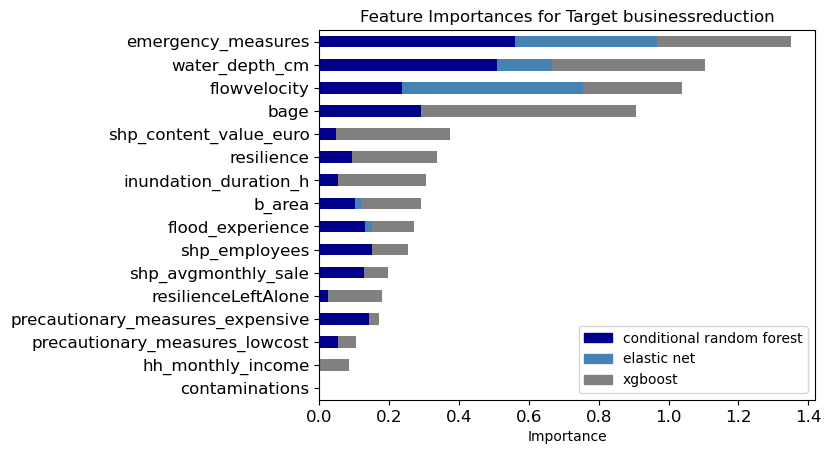

In [ ]:
### drop features which dont reduce the loss
df_feature_importances_plot = df_feature_importances#.loc[df_feature_importances.sum_all_importances_weighted > 0.01, : ] 
#df_feature_importances_plot = df_feature_importances.loc[df_feature_importances.sum_all_importances_weighted > 2, : ] 
#df_feature_importances_plot = df_feature_importances.sort_values("mean_all_importances_weighted", ascending=True)

plt.figure(figsize=(30, 22))
#df_feature_importances.plot.barh(
df_feature_importances_plot[["crf_importances_weighted", "en_importances_weighted", "xgb_importances_weighted",]].plot.barh(
    stacked=True, 
    #color="darkblue",
    color={"crf_importances_weighted":"darkblue", "en_importances_weighted":"steelblue", "xgb_importances_weighted":"grey"},
    width=0.5,
    # #errorbar="sd",
    # errorbar=("pi", 50), 
    # capsize=.1, errcolor=".5",
    # linewidth=3,
    )
plt.xlabel("Importance")
plt.ylabel("")
plt.title(f"Feature Importances for {target.replace('_',' ')}")


top_bar = mpatches.Patch(color="darkblue", label="conditional random forest")
middle_bar = mpatches.Patch(color="steelblue", label="elastic net")
bottom_bar = mpatches.Patch(color="grey", label="xgboost")
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.legend(handles=[top_bar, middle_bar, bottom_bar], loc="lower right")
#plt.tight_layout()
#plt.grid(None)

plt.show()

#sns.despine(left=True, bottom=True)
## save importance scores and figure
#filepath = f'./models_evaluation/best_xgb_importance_scores_{target}_{pipe_name}'
#if not glob(filepath):
#    df_importance.to_csv(filename, index = False)
#plt.savefig(f'../../../figures/best_en_feature_importance_{target}_{pipe_name}.png', bbox_inches='tight')



### Save final feature space 
The final selection of features is used later for the non-parametric Bayesian Network

In [ ]:
## sort features by their overall importance (weighted sum across across all features) , first column contains the target
final_feature_names = df_feature_importances.sort_values("sum_all_importances_weighted", ascending=False).index##[:10]

## drop records with missing target values
print(f"Dropping {df_candidates[f'{target}'].isna().sum()} records from entire dataset due that these values are nan in target variable")
df_candidates = df_candidates[ ~df_candidates[f"{target}"].isna()]
print(f"Keeping {df_candidates.shape[0]} records and {df_candidates.shape[1]} features")

fs.save_selected_features(
    df_candidates, 
    pd.DataFrame(df_candidates, columns=[target]), 
    final_feature_names,
    filename=f"../../../input_survey_data/final_data_{target.split('_',1)[-1].rsplit('_',1)[0]}_tueb.xlsx"
)


Dropping 36 records from entire dataset due that these values are nan in target variable
Keeping 357 records and 17 features
total features: 17
dropped features: 1
selected 16 features: 
['emergency_measures', 'water_depth_cm', 'flowvelocity', 'bage', 'shp_content_value_euro', 'resilience', 'inundation_duration_h', 'b_area', 'flood_experience', 'shp_employees', 'shp_avgmonthly_sale', 'resilienceLeftAlone', 'precautionary_measures_expensive', 'precautionary_measures_lowcost', 'hh_monthly_income', 'contaminations']

Saving model to disk: ../../../input_survey_data/final_data_businessreduction_tueb.xlsx


### Partial dependence
PDP shows the marginal effect that one or two features have on the predicted outcome. It shows whether the relationship between the target and a feature is linear, monotonic, or more complex ,as well as the direction of the relationship (see also Coefficients for linear regression tasks). It is introduced by J. H. Friedman and has been widely applied in machine learning modeling.

In [ ]:
# fit_params={"model__early_stopping_rounds":10, 
#             "model__eval_metric" : "mae", 
#             "model__eval_test_size": 50,
#             }
tst_final_model = RandomizedSearchCV( # GridSearchCV( 
            estimator=pipe,
            #param_grid=param_space,
            param_distributions=param_space,
            cv=cv, 
            scoring="neg_mean_absolute_error",
            refit=True,   
            random_state=seed,
        )

df_candidates_t_nonan = df_Xy.dropna()
tst_final_model.fit(
    df_candidates_t_nonan.drop(target, axis=1), 
    df_candidates_t_nonan[target],
    #**fit_params
)
final_models_trained["xgb_tst"] = tst_final_model.best_estimator_

[22:56:20] WARNING: D:\bld\xgboost-split_1685694922754\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "max_depth" } are not used.

[22:56:20] WARNING: D:\bld\xgboost-split_1685694922754\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "max_depth" } are not used.

[22:56:21] WARNING: D:\bld\xgboost-split_1685694922754\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "max_depth" } are not used.

[22:56:21] WARNING: D:\bld\xgboost-split_1685694922754\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "max_depth" } are not used.

[22:56:21] WARNING: D:\bld\xgboost-split_1685694922754\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "max_depth" } are not used.

[22:56:21] WARNING: D:\bld\xgboost-split_1685694922754\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "max_depth" } are not used.

[22:56:21] WARNING: D:\bld\xgboost-split_1685694922754\work\src\learner.cc:767: 
Parameters: { "colsample_bytree", "max_depth" } are not

In [ ]:
# ## TODO test with percenticels without nans


In [ ]:
# m = model_evaluation()
# t = m.decorator_func(model=final_models_trained["crf"], Xy=eval_sets["crf"], y_name=target, feature_name="flowvelocity", scale=True) (get_partial_dependence)() #model=final_models_trained["crf"], Xy=eval_set_list["en"]["en"], y_name=target, feature_name="flowvelocity", scale=False)
# t
## Q:
## how to simplyfy call of decorated function-> eg. second part of argumets for get_partial_dependence() is useless
## why call fun(*, **) inside wrapper(), or purpoe of @decorator(func)
## how to store multiple decorators: in the classes in which they decorate a func or in a seperate class eg. for only R-decorators

In [ ]:
class model_evaluation(object):
    """
    
    """    
    
    ## decorator for R model
    def decorator_func(self, model , Xy, y_name, feature_name, scale=True):
        """
        Decorator to get partial dependence instead of python-sklearn-model from R-party-model
        """
        def r_get_partial_dependence(func):
            def wrapper(*args, **kwargs):
    
                X = Xy.dropna().drop(y_name, axis=1)
        
                # scaled feature distributions in pd plots across models
                if scale:
                    X = pd.DataFrame(
                        MinMaxScaler().fit_transform(X),
                        columns=X.columns
                    )
                partial_dep = e.r_partial_dependence(
                    model, 
                    Xy,
                    feature_name
                    )
                #return func(*args, **kwargs)
                return fs.r_dataframe_to_pandas(partial_dep)
            
            return wrapper
        return r_get_partial_dependence


    #@decorator(model=final_models_trained["crf"], Xy=eval_set_list["crf"]["crf"], target_name=target, feature_name="flowvelocity", scale=True) 
    ## not using decorator @
    def get_partial_dependence(self, **kwargs):
        model= kwargs["model"]
        Xy = kwargs["Xy"]
        y_name = kwargs["y_name"]
        feature_name = kwargs["feature_name"]
        scale = kwargs["scale"]

        X = Xy.dropna().drop(y_name, axis=1)

        # scale feature distributions in pd plots across models
        if scale:
            X =  pd.DataFrame(
                MinMaxScaler().fit_transform(X),
                columns=X.columns
            )
        partial_dep = partial_dependence(   
            model,
            X=X,
            features=feature_name,
            grid_resolution=X.shape[0],
            kind="average", 
            **kwargs,
        )
        partial_dep_df = pd.DataFrame({
            feature_name : partial_dep.grid_values[0],
                "yhat": partial_dep.average[0]
            }
        )
        return partial_dep_df


In [44]:
## EN, XGB get partial dependences

## store partial dependences for each model
pdp_features = {a : {} for a in ["en", "xgb", "crf"]}

me = model_evaluation()


for model_name in ["crf", "xgb", "en"]:

    Xy_pdp = eval_sets[model_name].dropna() #  solve bug on sklearn.partial_dependece() which can not deal with NAN values
    X_pdp, y_pdp = Xy_pdp[Xy_pdp.columns.drop(target)], Xy_pdp[target]
    X_pdp = pd.DataFrame(
        MinMaxScaler().fit_transform(X_pdp), # for same scaled pd plots across models
        columns=X.columns
        )
    Xy_pdp = pd.concat([y_pdp, X_pdp], axis=1)

    for predictor_name in X.columns.to_list(): 
        features_info =  {
            #"percentiles" : (0.05, .95) # causes NAN for some variables for XGB if (0, 1)
            "model" : final_models_trained[model_name], 
            "Xy" : Xy_pdp, 
            "y_name" : target, 
            "feature_name" : predictor_name, 
            "scale"  : True
        }         

        if model_name != "crf":   
            print(predictor_name)
            partial_dep = me.get_partial_dependence(
                # model=final_models_trained[model_name], 
                # Xy=Xy_pdp, 
                # y_name=target, 
                # feature_name=predictor_name, 
                # scale=True,
                **features_info
            )
        else:  # process R models
            print("crf: ", predictor_name)
            partial_dep = me.decorator_func(       #  change function only temporally        
                # model=final_models_trained[model_name], 
                # Xy=Xy_pdp, 
                # y_name=target, 
                # feature_name=predictor_name, 
                # scale=True
                **features_info
            ) (me.get_partial_dependence)()

        pdp_features[model_name][predictor_name] = partial_dep



Exception ignored from cffi callback <function _callback at 0x0000029F3855F5E0>:
Traceback (most recent call last):
  File "c:\Anaconda\envs\py396_c3\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 329, in _callback
    try:
KeyboardInterrupt: 
Exception ignored from cffi callback <function _callback at 0x0000029F3855F5E0>:
Traceback (most recent call last):
  File "c:\Anaconda\envs\py396_c3\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 329, in _callback
    try:
KeyboardInterrupt: 


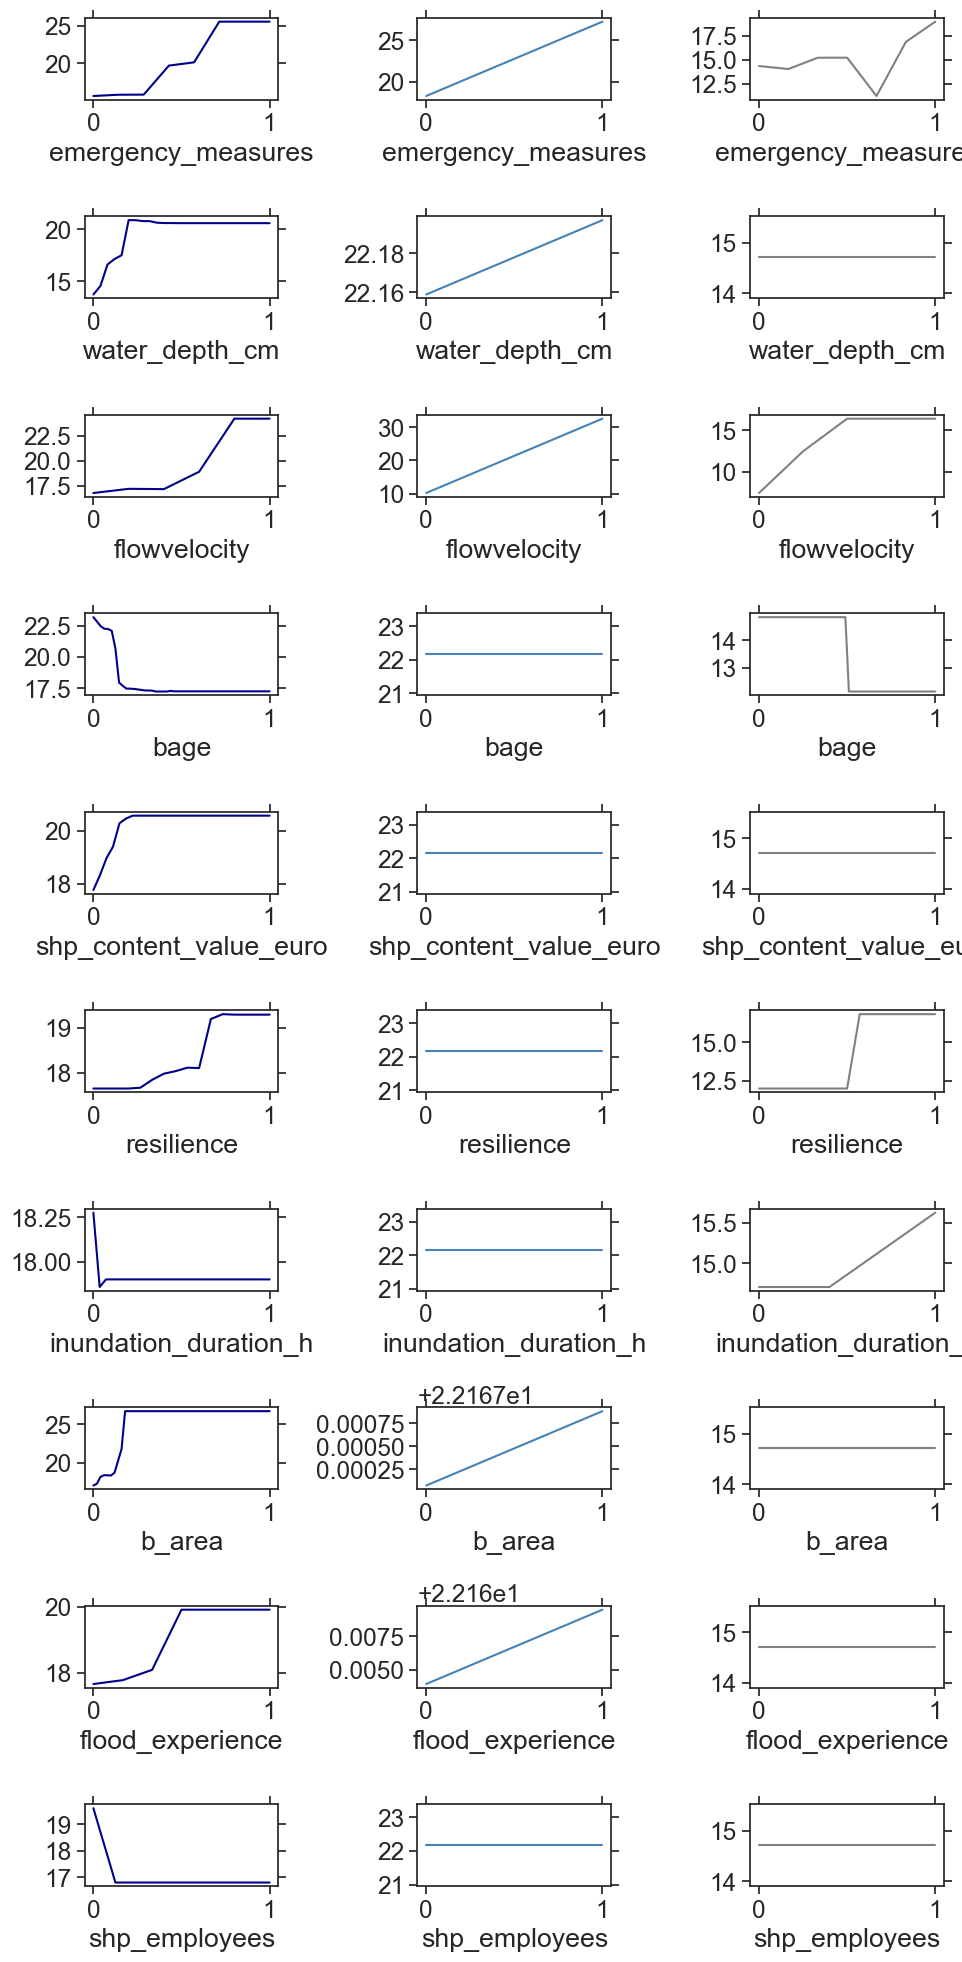

In [ ]:
plt.figure(figsize=(10,25))
#plt.subplots_adjust(hspace=0.9)
#plt.suptitle(f"Partial Dependences for {target}", fontsize=18, y=0.95)


most_important_features = df_feature_importances_plot.sort_values("sum_all_importances_weighted", ascending=False).index



idx = 0
categorical = [] # ["flowvelocity"]
ncols = 3
nrows = len(most_important_features[:10])

## create PDP for all three models
for feature in most_important_features[:10]:
    for model_name, color, idx_col in zip(["crf", "en", "xgb"], ["darkblue", "steelblue","grey"], [0, 1, 2]):
        
        # idx position of subplot
        ax = plt.subplot(nrows, ncols, idx + 1 + idx_col)
        feature_info = {"color" : color, "ax" : ax} 

        # plot
        df_pd_feature = pdp_features[model_name][feature]  
        p = f.plot_partial_dependence(
            df_pd_feature, feature_name=feature, partial_dependence_name="yhat", 
            categorical=[],
            **feature_info
            )
        p

    idx = idx + 3

#plt.subplots_adjust(top=0.2)
#plt.savefig("test_pdp.jpg", bbox_inches="tight")


- for large buidlings the en model predicts higher losses
- higher losses are also linked in the model with slightly less flood experience and higher flowvelocity ,
- model predicts for shops with very low registered capital less losses
- implmenting resistant building material after the flood (nb=4) is linked in the model with higher losses

### Empirical median ~ predicted median

And further statitics compared to their empirical counterpart.
-  mean /variance / std  compared to empirical distribution

In [ ]:
#model.predict()


In [ ]:
print("Testing models for : ", target)
e.empirical_vs_predicted(
    X, y,
    models_list = [models_trained["crf"], models_trained["xgb"]]#, models_trained["trained_en"]] 
    #models_trained#[f"trained_{model_name}_cv"]
    #models_list=[model, model_log, model_quantile, model_boxcox, model_sqrt]    
)

## TODO fix y empirical
# ## TODO idea: make a median/mean etc of best model as boxplots 8one (3 models for each target)


Testing models for :  Target_relative_contentloss_euro


AttributeError: 'ListVector' object has no attribute 'predict'

In [ ]:
# print(target)
# print(X.shape)

# df_importance

Target_relative_contentloss_euro
(133, 27)


,importances
shp_registered_capital_euro,0.156041
shp_employees,0.146143
contaminations.0,0.027468
water_barriers_impl,0.024416
flood_experience,0.024315
emergency_measures.4,0.023024
shp_sector,0.011757
b_area,0.010517
electricity_higher_impl,0.009988
bage,0.009262


In [ ]:
print("median entire ds")
print(np.median(y))
#print(np.median(model.predict(X)))
y_pred = model
print(np.median([outer_y_pred[{model_name}]]))

print("mean entire ds")
print(np.mean(y))
#print(np.mean(model.predict(X)))
y_pred = model
print(np.mean([outer_y_pred[{model_name}]]))


median entire ds
0.01000119482099409
0.04939702
mean entire ds
0.056081992063753514
0.060931973


In [ ]:
# importances = me.permutation_feature_importance(model, X_test, y_test, repeats=5, seed=seed)

# df_importance = pd.DataFrame(
#     {"importances" : importances[0]},
#     index=X_train.columns.to_list(),
#     ) 
# df_importance = df_importance.sort_values("importances", ascending=False)  # get most important features to the top
# print("Most important features:", df_importance.iloc[:5].index.to_list())
# #df_importance = df_importance.loc[df_importance.importances >= 0.000000, : ]

# df_importance

In [ ]:
model_cv.best_params_

y_train

##  MAE: + in target unit +  less likely to be affected by extreme values.
## MAPE: r (MAPE) quantifies the average absolute difference between 
## the anticipated and observed values of the target variable as a percentage of the observed value. 
## The method works well for assessing models where the target variable spans a broad range of scales

# 75 % in train mit 300 trress, subsam0.8, maxdep=3, aber bad teest R2


## R²-Score: 0.46
# {'model__validate_parameters': True,
#  'model__n_estimators': 800,
#  'model__max_depth': 10,
#  'model__eta': 0.2}


95      36.8
273    621.3
182    186.8
152     37.4
147    560.5
       ...  
185     44.7
275     39.7
40     644.3
234    382.7
268    223.4
Name: Target_contentloss_euro, Length: 132, dtype: float64

In [ ]:


##pipelines = ["pipe_bag_en"]#, 
pipelines = ["pipe_en" ]#
pipe_name = pipelines[0]

#model_eval = pickle.load(open(f"./models_trained/best_elasticnet_{target}_{pipe_name}.sav", 'rb'))
#elastic_net_eval.get_params()



In [ ]:
print('R^2 training set', round(model.score(X_train, y_train)*100, 2), ' %')
print('R^2 test set', round(model.score(X_test, y_test)*100, 2))

learning_rate = [0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]



## Plot tagret vs its log-transformed version

## Plot tagret vs its log-transformed version

R^2 training set 97.9  %
R^2 test set -49.21


In [ ]:
## Plot learning rate see if    
means = model_cv.cv_results_['mean_test_score']
stds = model_cv.cv_results_['std_test_score']
params = model_cv.cv_results_['params']

# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

# plot results
# scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
# for i, value in enumerate(learning_rate):
#     plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
# for mean, stdev, param in zip(means, stds, params):
# 	print("%f (%f) with: %r" % (mean, stdev, param))
# plot
#plt.use('Agg')
import matplotlib
matplotlib.use('Agg')


plt.errorbar(learning_rate, means, yerr=stds)
plt.legend()
plt.xlabel('learning_rate')
plt.ylabel('Log Loss')
plt.savefig('log_loss_vs_learning_rate.png')
plt.show()
# scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
# for i, value in enumerate(learning_rate):
#     plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
# plt.legend()
# plt.xlabel('learning_rate')
# plt.ylabel('Log Loss')
# plt.savefig('n_estimators_vs_learning_rate.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [ ]:
#plt.savefig(f"./models_trained/FI_{target}.png", bbox_inches='tight')
#sns_plot.figure.savefig("output.png")
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))


0.9790346135872993
-0.4921255591097222


### Plot prediction error 

In [ ]:
predicted_values["crf"]

KeyError: 'crf'

In [ ]:

f, (ax0, ax1) = plt.subplots( 2, 3,  sharey="row", figsize=(15, 8)) # 

for idx, model_abbre, model_name in zip([0, 1, 2], ["en", "xgb", "crf"], ["Elastic Net", "XGBoost", "Conditional Random Forest"]):
    
    y_true = predicted_values[model_abbre]["y_empirical"];  y_pred = predicted_values[model_abbre]["y_predicted"]

    PredictionErrorDisplay.from_predictions(
        y_true,
        y_pred,
        kind="actual_vs_predicted",
        ax=ax0[idx],
        scatter_kwargs={"alpha": 0.5},
    )
    ax0[idx].set_title(model_name)

    # Add the score in the legend of each axis
    # for ax, y_true, y_pred in zip([ax0[0], ax0[1], ax0[2]], [y_true_en, y_true_xgb, y_true_crf], [y_pred_en, y_pred_xgb, y_pred_crf]):
    for name, score in e.compute_score(y_true, y_pred).items():
        ax0[idx].plot(name, score, " ", label=f"{name}={score}")
    ax0[idx].legend(loc="upper right")


    # plot the residuals vs the predicted values
    PredictionErrorDisplay.from_predictions(
        y_true,
        y_pred,
        kind="residual_vs_predicted",
        ax=ax1[0],
        scatter_kwargs={"alpha": 0.5},
    )
    ax1[0].set_title(f"{model_name} regression ")


#f.suptitle("Synthetic data", y=1.05)
plt.tight_layout()


## reload models


#model_eval = pickle.load(open(f"./models_trained/xgboost_{target}_{pipe_name}.sav", 'rb'))
#model_eval.get_params()
#dir(model_eval)#.feature_importances_[model_eval.feature_importances_>0.015].shape

NameError: name 'plt' is not defined

## left overs

### save R model as Pmml and reload it into python readable version 

In [ ]:
# ## TODO impl PDP for CRF -> convert R vector to python .fit() object .e.g pickle .sav --> relaod as python obj
# # models_trained["crf"]#.keys()

# e1071 = importr("e1071")

# MODEL_SAVE_PATH = "crf_model"
# #DEP_LIBS = base.c("e1071")
# DEP_LIBS = base.c("party")


# # save model
# model_rds_path = base.paste(MODEL_SAVE_PATH, ".rds", sep='')
# base.saveRDS(models_trained["crf"], model_rds_path)

# # save dependency list
# model_dep_path = base.paste(MODEL_SAVE_PATH, ".dep", sep='')
# file_conn = base.file(model_dep_path)
# base.writeLines(DEP_LIBS, file_conn)
# base.close(file_conn)

In [ ]:
# pmml = importr("pmml")

In [ ]:
# # Export to PMML:
# pmod = pmml.pmml(models_trained["crf"])

# # Save to an external file:
# pmml.save_pmml(pmod, "crf_model.pmml")


In [ ]:
# from pypmml import Model
# m

In [ ]:
# m = Model.fromFile('crf_model.rds')
# result = mm.predict(X)

In [ ]:
# ## Make Python Class which Loads R Model
## https://goddoe.github.io/r/machine%20learning/2017/12/17/how-to-use-r-model-in-python.html

# import rpy2.robjects as robjects
# from rpy2.robjects import numpy2ri
# from rpy2.robjects.packages import importr

# r = robjects.r
# numpy2ri.activate()

# class R2PY_Model(object):
#     """
#     R Model Loader
#     model : R object
#     """

#     def __init__(self):
#         self.model = None

#     def load(self, path):
#         model_rds_path = "{}.rds".format(path)
#         model_dep_path = "{}.dep".format(path)

#         self.model = r.readRDS(model_rds_path)

#         with open(model_dep_path, "rt") as f:
#             model_dep_list = [importr(dep.strip())
#                               for dep in f.readlines()
#                               if dep.strip()!='']

#         return self

#     def predict(self, X):
#         """
#         Perform regression/classification on samples in X.
#         X : array, shape (n_samples, n_features)
#         return pred_probs : array, shape (n_samples, probs)
#         """

#         if self.model is None:
#             raise Exception("There is no Model")
        
#         if type(X) is not np.ndarray:
#             X = np.array(X)

#         #pred = r.predict(self.model, X, probability=True)
#         pred = r.predict(self.model, X, probability=False)
#         #probs = r.attr(pred, "probabilities")
#         #return np.array(probs)

#         return np.array(pred)


In [ ]:
# ## Load R Model Using rpy2 Wrapper Class and Run Example
# #from rpy2_wrapper.model import Model

# # Constants
# MODEL_PATH = "crf_model"

# # Example Input
# Xy = np.array([[5.1, 3.5,  1.4, 0.2], # setosa
#               [6.1, 2.6,  5.6, 1.4]] ) # virginica

# # Example Run
# model = R2PY_Model().load(MODEL_PATH) # model_rds_path
# # Xy = pd.concat(
# #         [y.reset_index(), X],
# #         axis=1,
# #     ).drop("index", axis=1)
# pred = model.predict(Xy)

# # Example output
# print(pred)

In [ ]:
# ?model

### outdated -Feature importance
Have the same feature importance method across all applied ML models


In [ ]:

# df_importance_package = pd.DataFrame({
#     "name" : X_train.columns.to_list(),
#     "importances" : model.feature_importances_,
#      }) 
# df_importance_package.sort_values("importances", ascending=False)[:10]

In [ ]:
# ## Permuation feature importance
# result = e.permutation_feature_importance(model, X_test, y_test, repeats=5, seed=seed)

# df_importance = pd.DataFrame({
#     "name" : X_train.columns.to_list(),
#     "importances" : result[0],
# #    "importances" : np.abs(result[0]),
#      }) 
# df_importance = df_importance.sort_values("importances", ascending=True)  # get most important features to the top
# df_importance.tail(18)

### plot feature importance


In [218]:
# # reload evalation set
# eval_set = eval_set_list[0]#[pipe_name]


# importances = e.permutation_feature_importance(model_sqrt, 
# #importances = e.permutation_feature_importance(model, 
#                                                X_test,
#                                                y_test,
#                                                #eval_set.drop(target, axis=1), 
#                                                #eval_set[target], 
#                                                repeats=5, seed=seed
#                                                )

# ## feature importance scores
# df_importance = pd.DataFrame({
#     "name" : X.columns.to_list(),
#     "importances" : importances[0],
#      }) 

# # drop features which dont reduce the loss
# df_importance = df_importance.loc[df_importance.importances > 0.0000, : ] 
# df_importance = df_importance.sort_values("importances", ascending=False)


# #fig, ax = plt.subplots(figsize=(12,5))
# plt.figure(figsize=(8, 5))
# #plt.barh(df_importance.name, df_importance.importances)
# #plt.barh(df_importance.name[-18:], df_importance.importances[-18:])

# sns.barplot(
#     data=df_importance, 
#     x="importances", y="name",
#     width=0.4,
#     color='steelblue',
#     #errorbar="sd",
#     errorbar=("pi", 50), 
#     capsize=.1, errcolor=".5",
#     linewidth=3, #edgecolor=".3", #facecolor=(0,0,0,0),
# )
# plt.ylabel("")
# plt.xticks(
#     rotation = 90
#     )
# plt.title(f"XGBoost (sqrt-transformed): Feature Importances for {target}")
# plt.show()

# ## save importnace scores  and figure
# #filepath = f'./models_evaluation/best_xgb_importance_scores_{target}_{pipe_name}'
# #if not glob(filepath):
# #    df_importance.to_csv(filename, index = False)


# #plt.savefig(f'../../../figures/best_en_feature_importance_{target}_{pipe_name}.png', bbox_inches='tight')





### partial dependencies

In [ ]:
# fig, ax = plt.subplots(figsize=(12, 6))
# ax.set_title("Decision Tree")
# tree_disp = PartialDependenceDisplay.from_estimator(models_trained["trained_xgb"], pd.DataFrame(X, columns=X.columns), ["shp_employees"], ax=ax)
#tree_disp = PartialDependenceDisplay.from_estimator(model, pd.DataFrame(X, columns=X.columns), ["shp_employees"], ax=ax)

tree_disp = PartialDependenceDisplay.from_estimator(models_trained["trained_en"], pd.DataFrame(X, columns=X.columns), ["shp_employees"])
mlp_disp = PartialDependenceDisplay.from_estimator(
    models_trained["trained_xgb"], pd.DataFrame(X, columns=X.columns), ["shp_employees"], ax=tree_disp.axes_, line_kw={"color": "red"}
)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
# tree_disp.plot(ax=[ax1, ax2], line_kw={"label": "Decision Tree"})
# tree_disp.plot(
#     ax=[ax1, ax2], line_kw={"label": "Multi-layer Perceptron", "color": "red"}
# )
# ax1.legend()
# ax2.legend()

##### Hierarchical clustering on Spearman rank correlation

Select only feautres with low collienarity to solve disadvantage of perumation feature importance.
Randomizing one feature would lead to only small importance score - the model performance wouldnt be move influenced - due that the information is included in other correlated features. Removing one feature keeps the similar inforamtion in the other feautres unchanged and the model learns from the correlated feature. Therefore apply hierachical clustering to select less correlated features

See also:
- Brill 2020 (dissertation)
- https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html # code example
- https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py # code example

In [ ]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(df_candidates).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=df_candidates.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

# ax1.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
# ax1.set_xticks(dendro_idx)
# ax1.set_yticks(dendro_idx)
# ax1.set_xticklabels(dendro["ivl"], rotation="vertical")
# ax1.set_yticklabels(dendro["ivl"])
# _ = fig.tight_layout()


In [ ]:
# import scipy.cluster.hierarchy as shc

# plt.figure(figsize=(15, 10))
# plt.title("Customers Dendrogram")

# # Selecting Annual Income and Spending Scores by index
# selected_data = X_train.dropna()
# selected_data = selected_data.T # only possible with out nan
# clusters = shc.linkage(selected_data, 
#             method='ward', optimal_ordering=False,
#             metric="euclidean")
# shc.dendrogram(Z=clusters, 
#                #p=20, # p -> value for truncation mode
#                orientation="right",
#                labels=X_train.columns
#                ) 
# plt.show()

# ## TODO adapt with spearman rank order



In [ ]:

# from scipy.stats import spearmanr
# from scipy.spatial.distance import squareform
# from scipy.cluster.hierarchy import ward, dendrogram

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
# corr = spearmanr(X_unscaled_no_nan).correlation

# # Ensure the correlation matrix is symmetric
# corr = (corr + corr.T) / 2
# np.fill_diagonal(corr, 1)

# # We convert the correlation matrix to a distance matrix before performing
# # hierarchical clustering using Ward's linkage.
# distance_matrix = 1 - np.abs(corr)
# dist_linkage = ward(distance_matrix, checks=False )
# dendro = dendrogram(
#     dist_linkage, labels=X_unscaled_no_nan.columns.tolist(), ax=ax1, leaf_rotation=90
# )
# dendro_idx = np.arange(0, len(dendro["ivl"]))

# ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
# ax2.set_xticks(dendro_idx)
# ax2.set_yticks(dendro_idx)
# ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
# ax2.set_yticklabels(dendro["ivl"])
# fig.tight_layout()

# cluster_ids = shc.fcluster(dist_linkage, 1, criterion="distance")
# cluster_id_to_feature_ids = defaultdict(list)
# for idx, cluster_id in enumerate(cluster_ids):
#     cluster_id_to_feature_ids[cluster_id].append(idx)
# selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

# X_train_sel = X_train[:, selected_features]
# X_test_sel = X_test[:, selected_features]



In [ ]:
# closs hyperapram , no model__early_stopping_rounds, repeatedcv wit h10 folds
## best train R2: ntree=30, max_depth =1, no furhter params

# learning_rate = [ 0.00001, 0.0001, 0.001, 0.1, 0.2]#, 0.3, 0.4, 0.5, 0.6, 0.8, 0.9] # store outside, for plotting
# n_estimators = [ 50, 100, 200, 300, 500, 800]

# param_space = {'model__n_estimators': n_estimators,
#     #'model__n_estimators': [ 3, 5, 10, 20], # get only low train scores with this
#               'model__max_depth': [1, 2, 3, 5, 7, 8, 10, 15],
#               #'model__max_leaves': [0, 3, 5],
#              # 'model__colsample_bytree': [ 0.3, 0.5, 0.7, 1.0 ], # Percentage of columns to be randomly samples for each tree
#              # 'model__colsample_bynode': [ 0.3, 0.5, 0.7, 1.0], # nbr of feautres for each split point
#              # 'model__eta': learning_rate,  # == eta
#             #   'model__gamma': [0.2, 0.3, 0.5, 0.8, 1, 3] , # min_split_loss -  larger gamma is, the more conservative the algorithm is
#               'model__subsample': [0.0, 0.2, 0.5, 0.6, 0.8, 0.9],  # define subsample of train st prior to growing trees, prevent overfitting
#             #  'model__reg_alpha': [0.5, 1.0, 2.0, 4.0, 5.0, 6.0 ,7.0],   # Lasso Regularization term on weights , higher values = more consrvative 
#             #  'model__reg_lambda': [0.0, 0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0],  # Ridge Regularization term on weights ,  higher values = more consrvative
#             #   'model__min_child_weight': [0, 1, 2, 3, 4,],
#             #   "model__max_delta_step":  [0, 3, 5, 6, 7],           # for LogisticReg good to solve imbalance 
#           #   'model__objective': [None, 'reg:absoluteerror'],#'multi:softprob,'reg:squarederror','reg:models_trained'],
#           #  # 'model__tree_method': ["hist", "gpu_hist"],
#           #   'model__booster': [None, "gblinear", "gbtree"],
#             "model__validate_parameters":[True],
#               }

# # 'model__scale_pos_weight': [0.0, 0.3, 0.5, 0.7, 0.9, 1.0],  # only  for clasifcation: handle imbalance, ratio between negative and positive examples

# # Objective candidate: multi:softmax
# # Objective candidate: multi:softprob
# # Objective candidate: reg:squarederror
# # Objective candidate: reg:squaredlogerror
# # Objective candidate: reg:logistic
# ## Objective candidate: reg:linear
# # Objective candidate: reg:pseudohubererror
# # Objective candidate: reg:gamma
# # Objective candidate: reg:absoluteerror

# ## DOC: https://xgboost.readthedocs.io/en/stable/parameter.html
